## Importing the dataset and exploring it

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
!tar -xf drive/'My Drive'/'Colab Notebooks'/Project/NBST.tar

tar: Removing leading `/' from member names


In [0]:
!rm -r dataset

In [0]:
!rm -r dataset/img/train

In [0]:
!mkdir dataset/masks_machine/train

In [0]:
os.mkdir('dataset/img/train')

In [175]:
ls dataset/img/val

0004.jpg  0021.jpg  0057.jpg  0119.jpg  0148.jpg  0183.jpg  0213.jpg  0242.jpg
0005.jpg  0030.jpg  0084.jpg  0120.jpg  0151.jpg  0189.jpg  0220.jpg  0243.jpg
0006.jpg  0045.jpg  0087.jpg  0125.jpg  0152.jpg  0190.jpg  0221.jpg  0246.jpg
0007.jpg  0046.jpg  0093.jpg  0133.jpg  0160.jpg  0202.jpg  0223.jpg  0255.jpg
0009.jpg  0047.jpg  0097.jpg  0136.jpg  0161.jpg  0206.jpg  0226.jpg  0262.jpg
0012.jpg  0052.jpg  0098.jpg  0142.jpg  0177.jpg  0208.jpg  0228.jpg
0017.jpg  0053.jpg  0112.jpg  0143.jpg  0182.jpg  0212.jpg  0234.jpg


### Split into train and val subfolders

In [0]:
import glob
from shutil import copyfile
import os
import random

train_portion = .8

train_idx = sorted(random.sample(range(0, 262), int(262*train_portion)))
print("train_idx", train_idx)

val_idx = [item for item in range(0,263) if item not in train_idx]
print("val_idx",val_idx)



img_list = sorted(glob.glob("dataset/img/*.jpg"))

os.mkdir('dataset/masks_machine/train')
os.mkdir('dataset/img/train')
os.mkdir('dataset/masks_machine/val')
os.mkdir('dataset/img/val')
    
for id in range(len(img_list)):
  if id in train_idx:
    print("copy ", str(id).zfill(4), "to train")

    copyfile("dataset/img/"+str(id).zfill(4)+".jpg", "dataset/img/train/"+str(id).zfill(4)+".jpg")
    copyfile("dataset/masks_machine/"+str(id).zfill(4)+".png", "dataset/masks_machine/train/"+str(id).zfill(4)+".png")
  else:
    print("copy ", str(id).zfill(4), "to val")

    copyfile("dataset/img/"+str(id).zfill(4)+".jpg", "dataset/img/val/"+str(id).zfill(4)+".jpg")
    copyfile("dataset/masks_machine/"+str(id).zfill(4)+".png", "dataset/masks_machine/val/"+str(id).zfill(4)+".png")   


In [163]:
import scipy as sp
import scipy.misc
import imageio
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f2361086f98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


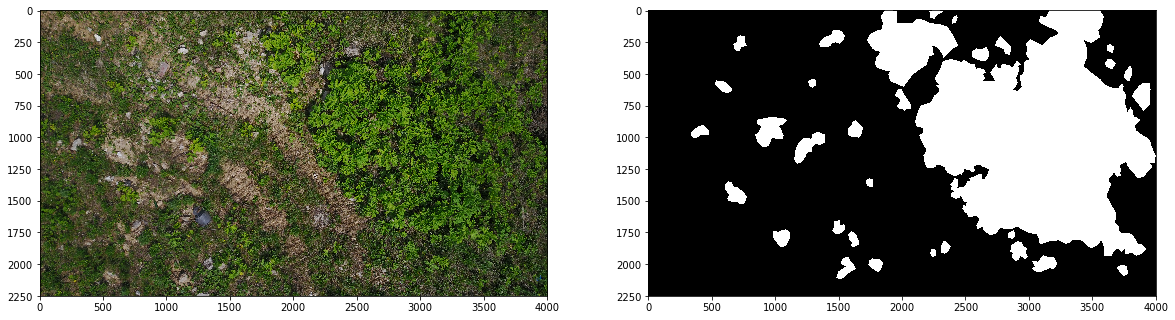

In [25]:
plt.figure(figsize=(20,16))
plt.subplot(1,2,1)
# im = sp.misc.imread('dataset/img/0110.jpg')
im = np.array(imageio.imread('dataset/img/0001.jpg'))
plt.imshow(im)
plt.subplot(1,2,2)
#mask = sp.misc.imread('dataset/masks_machine/0110.png')
mask = np.array(imageio.imread('dataset/masks_machine/0001.png'))[:,:,0]
plt.imshow(mask, 'gray')

In [26]:
im.shape, mask.shape

((2250, 4000, 3), (2250, 4000))

##Uploading the SegNet

https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/models/segnet.py

In [64]:
from google.colab import files
uploaded = files.upload()

Saving ptsemseg.zip to ptsemseg.zip


In [0]:
!unzip ptsemseg.zip

In [66]:
ls

dataset/  drive/  meta.json  models/  ptsemseg/  ptsemseg.zip  sample_data/


In [0]:
from ptsemseg.models import segnet

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.special import expit
from torch.utils.data import Dataset 
from PIL import Image
import random
from torchvision import transforms
import torch.utils.data as data_utils
import os
import time
from IPython import display  

##Create paths to data

In [3]:
from os import listdir
from os.path import isfile, join

def get_file_list(mypath):
  files = [f for f in sorted(listdir(mypath)) if isfile(join(mypath, f))]
  train_paths = [mypath + s for s in files]
  return train_paths

train_img_paths = get_file_list('dataset/img/train/')
train_mask_paths = get_file_list('dataset/masks_machine/train/')

val_img_paths = get_file_list('dataset/img/val/')
val_mask_paths = get_file_list('dataset/masks_machine/val/')

test_img_paths = get_file_list('dataset/img/test/')

print((train_img_paths))
print((train_mask_paths))

print((val_img_paths))
print(val_mask_paths)

print(test_img_paths)

['dataset/img/train/0000.jpg', 'dataset/img/train/0001.jpg', 'dataset/img/train/0002.jpg', 'dataset/img/train/0003.jpg', 'dataset/img/train/0008.jpg', 'dataset/img/train/0010.jpg', 'dataset/img/train/0011.jpg', 'dataset/img/train/0013.jpg', 'dataset/img/train/0014.jpg', 'dataset/img/train/0015.jpg', 'dataset/img/train/0016.jpg', 'dataset/img/train/0018.jpg', 'dataset/img/train/0019.jpg', 'dataset/img/train/0020.jpg', 'dataset/img/train/0022.jpg', 'dataset/img/train/0023.jpg', 'dataset/img/train/0024.jpg', 'dataset/img/train/0025.jpg', 'dataset/img/train/0026.jpg', 'dataset/img/train/0027.jpg', 'dataset/img/train/0028.jpg', 'dataset/img/train/0029.jpg', 'dataset/img/train/0031.jpg', 'dataset/img/train/0032.jpg', 'dataset/img/train/0033.jpg', 'dataset/img/train/0034.jpg', 'dataset/img/train/0035.jpg', 'dataset/img/train/0036.jpg', 'dataset/img/train/0037.jpg', 'dataset/img/train/0038.jpg', 'dataset/img/train/0039.jpg', 'dataset/img/train/0040.jpg', 'dataset/img/train/0041.jpg', 'dataset/

In [0]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.functional import to_tensor
import numpy as np

def get_box(img, crop_size):
    w, h = img.size
    
    if w == crop_size and h == crop_size:
        return 0, 0, h, w
      
    i = np.random.randint(0, w - crop_size)
    j = np.random.randint(0, h - crop_size)
    
    return i, j, i + crop_size, j + crop_size

class MyDataset(Dataset):
   
    def __init__(self, img_paths, mask_paths, crop_size=512, is_train=True):

        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.crop_size = crop_size
        #self.images_names = list(map(lambda x: x[:-3] , os.listdir(self.img_dir)))
        self.is_train = is_train

    def __len__(self):
        #return len(self.images_names)
        return len(self.img_paths)

    def __getitem__(self, idx):
#         img_name = os.path.join(self.img_dir,
#                                 self.images_names[idx] + 'jpg')
#         image = Image.open(img_name)
        image = Image.open(self.img_paths[idx]).resize((256, 256))
        
        if not self.mask_paths: # for test images
            return torch.Tensor(np.array(image)).permute(2,0,1) / 255 # ChannNumb, W, H
    
#         mask_name = os.path.join(self.mask_dir,
#                                  self.images_names[idx] + 'png')
#         mask = Image.open(mask_name)
        mask = Image.open(self.mask_paths[idx]).resize((256, 256))
        
        crop_box = get_box(image, self.crop_size)
        image = image.crop(crop_box)
        mask = mask.crop(crop_box)
    

    
#         if self.is_train:
        	
# #             crop_box = get_box(image, self.crop_size)
            
# #             image = image.crop(crop_box)
# #             mask = mask.crop(crop_box)

#             hflip = np.random.randn(1) > 0.5
#             if hflip:
#                 image = image.transpose(Image.FLIP_LEFT_RIGHT)
#                 mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
#             vflip = np.random.randn(1) > 0.5
#             if vflip:
#                 image = image.transpose(Image.FLIP_TOP_BOTTOM)
#                 mask = mask.transpose(Image.FLIP_TOP_BOTTOM)
            
#             angle = np.random.randint(-90, 90) 
#             image = image.rotate(angle)
#             mask = mask.rotate(angle)

        
        mask = np.array(mask)[:,:,0].astype(np.float32)
        
        image = torch.Tensor(np.array(image)).permute(2,0,1) / 255 # ChannNumb, W, H
        #image = image.type(torch.FloatTensor)
#         mask = torch.Tensor(mask) #torch.from_numpy(mask)
      
        return image, mask.reshape(1,self.crop_size,self.crop_size)

In [0]:
train_dataset = MyDataset(train_img_paths, train_mask_paths, crop_size=256)
train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=5,
                                              shuffle=True,
                                              num_workers=10)

# val_dataset = MyDataset(val_img_paths, val_mask_paths, crop_size=512, is_train=False)
# val_batch_gen = torch.utils.data.DataLoader(val_dataset,
#                                             batch_size=2,
#                                             shuffle=False,
#                                             num_workers=10)

In [93]:
print(train_dataset[10][0].shape, train_dataset[10][0].type())
print(train_dataset[10][1].shape, (train_dataset[10][1]).dtype)

torch.Size([3, 256, 256]) torch.FloatTensor
(1, 256, 256) float32


In [0]:
train_dataset[15][0].permute(1,2,0).shape
# a.permute(3,2,1,0).size()

torch.Size([500, 500, 3])

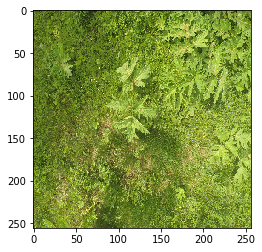

In [94]:
plt.imshow(train_dataset[15][0].permute(1,2,0))

(1, 256, 256)


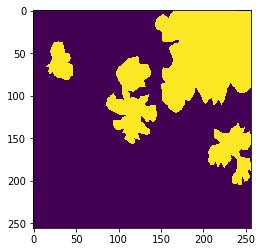

In [98]:
print(train_dataset[15][1].shape)
plt.imshow(train_dataset[15][1].reshape(256,256))

In [0]:
model = segnet(n_classes=1).cuda()

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

train_loss = []
val_accuracy = []

In [101]:
for (X_batch, y_batch) in train_batch_gen:

    X_batch = Variable(X_batch).cuda(); print("X_batch.shape", X_batch.shape); print("X_batch.type", X_batch.type())
    y_batch = Variable(y_batch).cuda(); print("\ny_batch.shape", y_batch.shape); print("y_batch.type", y_batch.type())
    logits = model(X_batch); print("\nlogits.shape", logits.shape); print("logits.type", logits.type()); 
    loss = F.binary_cross_entropy_with_logits(logits, y_batch)
    break

X_batch.shape torch.Size([5, 3, 256, 256])
X_batch.type torch.cuda.FloatTensor

y_batch.shape torch.Size([5, 1, 256, 256])
y_batch.type torch.cuda.FloatTensor

logits.shape torch.Size([5, 1, 256, 256])
logits.type torch.cuda.FloatTensor


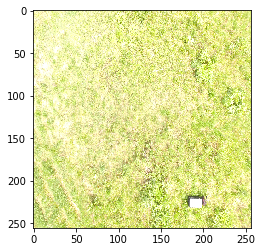

In [124]:
plt.imshow(X_batch[2].cpu().permute(1,2,0))

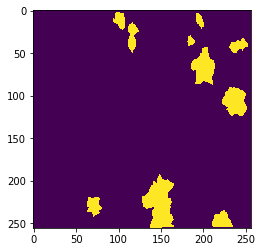

In [125]:
plt.imshow(y_batch[2].cpu().view(-1,256))

In [0]:
# def calc_iou(prediction, ground_truth):
#     n_images = len(prediction)
#     intersection, union = 0, 0
#     for i in range(n_images):
#         intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
#         union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
#     return float(intersection) / union

#Train

In [126]:
for epoch in range(num_epochs):
    start_time = time.time()
    model.train(True)
    loss_batch = []
    for (X_batch, y_batch) in train_batch_gen:
        
        X_batch = Variable(X_batch).cuda()
        y_batch = Variable(y_batch).cuda()
        
        logits = model(X_batch)
        loss = F.binary_cross_entropy_with_logits(logits, y_batch)

        loss.backward()
        opt.step()
        opt.zero_grad()
        loss_batch.append(loss.data.cpu().numpy()) # [0]
    train_loss.append(np.mean(loss_batch))

#     model.train(False)
#     val_iou = []
#     for (X_batch, y_batch) in val_batch_gen:
#         logits = model(Variable(X_batch, volatile=True).cuda())
#         y_pred = logits.data.cpu().numpy()
#         val_iou.append(calc_iou(expit(y_pred) > 0.33, y_batch.numpy()))
        
#     val_accuracy.append(np.mean(val_iou))
    # The results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss[-1]))
#     print("  validation iou:\t\t{:.2f} %".format(val_accuracy[-1] * 100))

Epoch 1 of 100 took 59.012s
  training loss (in-iteration): 	0.713570
Epoch 2 of 100 took 57.281s
  training loss (in-iteration): 	0.693182
Epoch 3 of 100 took 57.852s
  training loss (in-iteration): 	0.693223
Epoch 4 of 100 took 58.014s
  training loss (in-iteration): 	0.693148
Epoch 5 of 100 took 57.154s
  training loss (in-iteration): 	0.693148
Epoch 6 of 100 took 55.390s
  training loss (in-iteration): 	0.693147
Epoch 7 of 100 took 56.943s
  training loss (in-iteration): 	0.693148
Epoch 8 of 100 took 57.487s
  training loss (in-iteration): 	0.693147
Epoch 9 of 100 took 55.607s
  training loss (in-iteration): 	0.693595
Epoch 10 of 100 took 56.662s
  training loss (in-iteration): 	0.693150
Epoch 11 of 100 took 56.540s
  training loss (in-iteration): 	0.693147
Epoch 12 of 100 took 58.156s
  training loss (in-iteration): 	0.693147
Epoch 13 of 100 took 56.299s
  training loss (in-iteration): 	0.693147


KeyboardInterrupt: ignored

#Test the model

In [0]:
test_dataset = MyDataset(test_img_paths, mask_paths=None, crop_size=256, is_train=False)
test_batch_gen = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=1,
                                            shuffle=False,
                                            num_workers=3)

In [0]:
mask_list = []
for image in test_batch_gen:
    mask_list.append(expit(model(Variable(image).cuda()).data.cpu().numpy()) > 0.30)
mask_list = np.array(mask_list)

In [189]:
model(Variable(image).cuda()).data.cpu().numpy()

array([[[[0.        , 0.00061694, 0.01555286, ..., 0.0017481 ,
          0.00276726, 0.00538295],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.01773684],
         [0.        , 0.        , 0.00776873, ..., 0.        ,
          0.00272096, 0.        ],
         ...,
         [0.        , 0.00898626, 0.        , ..., 0.        ,
          0.00484012, 0.00112944],
         [0.01120758, 0.        , 0.01148586, ..., 0.00435931,
          0.        , 0.0028646 ],
         [0.00083456, 0.00017774, 0.        , ..., 0.        ,
          0.        , 0.0055064 ]]]], dtype=float32)

In [190]:
expit(model(Variable(image).cuda()).data.cpu().numpy())

array([[[[0.5       , 0.50015426, 0.50388813, ..., 0.500437  ,
          0.50069183, 0.50134575],
         [0.5       , 0.5       , 0.5       , ..., 0.5       ,
          0.5       , 0.5044341 ],
         [0.5       , 0.5       , 0.50194216, ..., 0.5       ,
          0.50068027, 0.5       ],
         ...,
         [0.5       , 0.50224656, 0.5       , ..., 0.5       ,
          0.50121003, 0.50028235],
         [0.50280184, 0.5       , 0.50287145, ..., 0.5010898 ,
          0.5       , 0.50071615],
         [0.5002086 , 0.50004447, 0.5       , ..., 0.5       ,
          0.5       , 0.50137657]]]], dtype=float32)

In [188]:
expit(model(Variable(image).cuda()).data.cpu().numpy()) > 0.30

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]]])

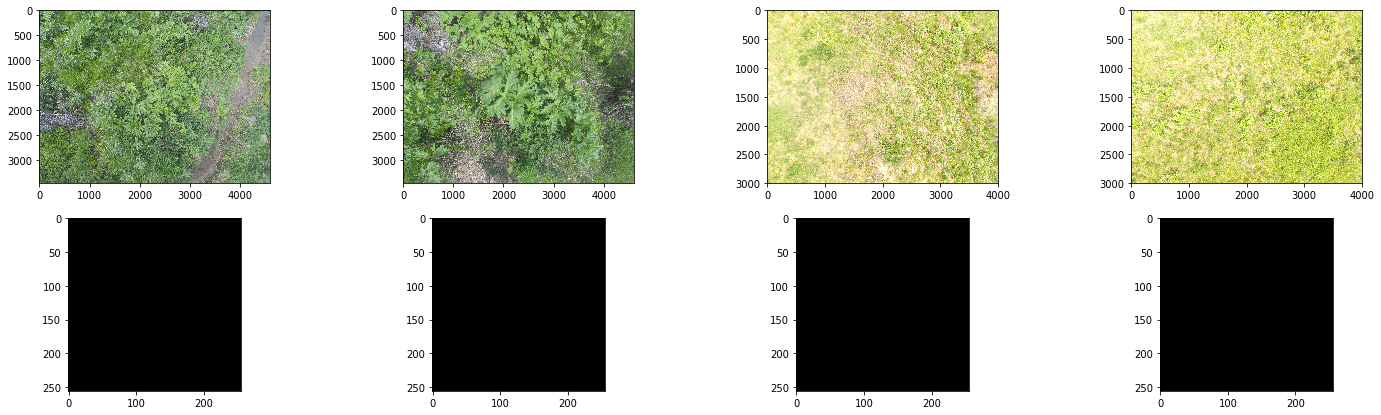

In [186]:
plt.figure(figsize=(25,7))
for i, img_path, gt in zip(range(mask_list.shape[0]), test_img_paths, mask_list):
    plt.subplot(2, len(mask_list), i+1)
    plt.imshow(imageio.imread(img_path))
    plt.subplot(2, len(mask_list), i+1 + mask_list.shape[0])
    plt.imshow(gt[0, 0, :, :], 'gray')

In [167]:
image = np.array(imageio.imread('dataset/img/0001.jpg'))
image = torch.Tensor(np.array(image)).permute(2,0,1) / 255
expit(model(Variable(image).cuda()).data.cpu().numpy()) > 0.30

RuntimeError: ignored

In [0]:
plt.figure(figsize=(25,7))
for i, img_path, gt in zip(range(mask_list.shape[0]), val_img_paths, mask_list):
    plt.subplot(2, len(mask_list), i+1)
    plt.imshow(sp.misc.imread(img_path))
    plt.subplot(2, len(mask_list), i+1 + mask_list.shape[0])
    plt.imshow(gt[0, 0, :, :], 'gray')

In [0]:
# ! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
# ! unzip -q data.zip

--2019-04-24 07:37:06--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2019-04-24 07:37:06--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc8caac0549fd3613313d50189c.dl.dropboxusercontent.com/cd/0/inline/AfmWk0OpXj72KcX0bshh_14PmNl01Jsi-FJ5AWWPo29aqBU4KgWPQY_lrgSyGnt_gwq_LStlOFTHKrlXFp9PMM7EiasLD3VHEjN9rlLNjjZu6A/file# [following]
--2019-04-24 07:37:07--  https://ucc8caac0549fd3613313d50189c.dl.dropboxusercontent.com/cd/0/inline/AfmWk0OpXj72KcX0bshh_14PmNl01Jsi-FJ5AWWPo29aqBU4KgWPQY_lrgSyGnt_gwq_LStlOFTHKrlXFp9PMM7EiasLD3VHEjN9rlLNjjZu6A/file
Resolving ucc8caac0549fd36

In [0]:
ls

BBBC018_v1_images-fixed/  BBBC018_v1_outlines/  data.zip  sample_data/


Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [0]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


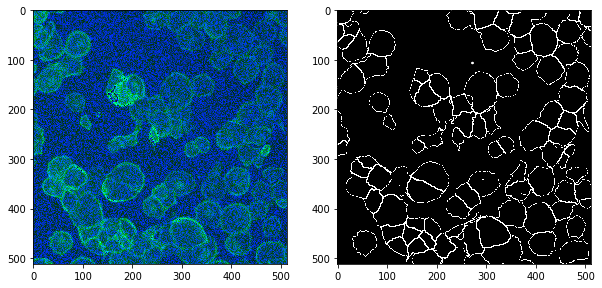

In [0]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [0]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.special import expit
from torch.utils.data import Dataset 
from PIL import Image
import random
from torchvision import transforms
import torch.utils.data as data_utils
import os
import time
from IPython import display  

# -------------
## Unet from https://github.com/milesial/Pytorch-UNet
Unet architecture (combination of down and up convolutions (mixed with batchnorm, nonlinearities, maxpooling, upsampling)) is good choice to be applied to segmentation tasks for high resolution images (512*512 in our case)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [0]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

## create paths to data

In [0]:
from os import listdir
from os.path import isfile, join

def get_file_list(mypath):
  files = [f for f in sorted(listdir(mypath)) if isfile(join(mypath, f))]
  train_paths = [mypath + s for s in files]
  return train_paths

train_img_paths = get_file_list('BBBC018_v1_images-fixed/train/')
train_mask_paths = get_file_list('BBBC018_v1_outlines/train/')

val_img_paths = get_file_list('BBBC018_v1_images-fixed/val/')
val_mask_paths = get_file_list('BBBC018_v1_outlines/val/')

print((train_img_paths))
print((train_mask_paths))

print((val_img_paths))
print(val_mask_paths)

['BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/00736-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/03997-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/03998-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/03999-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/04000-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05621-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05622-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05623-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05897-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05898-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05900-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/07314-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/07315-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/07316-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/09338-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/09339-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/09340-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/10777-actin.DI

## Define transformations
Requires la ot of GPU memory, which is sad, probably could be applied sequaentially

In [0]:
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

img_transform = transforms.Compose([
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation([-30, 30]),
#     transforms.ColorJitter(brightness=0.4, contrast=0.4)(anchors),
#     transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

mask_transform = transforms.Compose([
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation([-30, 30]),
#     transforms.ColorJitter(brightness=0.4, contrast=0.4)(anchors),
#     transforms.RandomVerticalFlip(),
])

val_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(means, stds),
])

# Not anough memoty for more transforms :(((

In [0]:
class ImgDataset(data_utils.Dataset):
    def __init__(self, 
                 img_paths, 
                 mask_paths, 
                 img_transform=None, 
                 mask_transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.img_transform = img_transform
        self.mask_transform = mask_transform
    
    
    def __getitem__(self, index):
      # https://github.com/pytorch/vision/issues/9#issuecomment-304224800
        
        image = Image.open(self.img_paths[index])
        if self.img_transform:
            seed = np.random.randint(2147483647) # make a seed with numpy generator 
            random.seed(seed) # apply this seed to img tranfsorms
            image = self.img_transform(image)        
        if not self.mask_paths: # for test images
            return image
        
        mask = Image.open(self.mask_paths[index])
        if self.mask_transform:
            random.seed(seed)
            mask = self.mask_transform(mask)
        mask = (np.array(mask, dtype=np.float32)[None, :, :] > 0).astype(np.float32)
        
        return image, mask

      
    def __len__(self):
        return len(self.img_paths)

In [0]:
train_dataset = ImgDataset(train_img_paths, train_mask_paths, img_transform=img_transform, mask_transform=mask_transform)
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=16,
                                              shuffle=True,
                                              num_workers=10)

val_dataset = ImgDataset(val_img_paths, val_mask_paths, img_transform=val_transform, mask_transform=None)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=3,
                                            shuffle=False,
                                            num_workers=10)

In [0]:
unet = UNet(n_channels=3, n_classes=1).cuda()

In [0]:
opt = torch.optim.Adam(unet.parameters(), lr=1e-3)
num_epochs = 100

train_loss = []
val_accuracy = []

In [0]:
# slow down the learning rate for 30 more epochs
opt = torch.optim.Adam(unet.parameters(), lr=0.1*1e-3)
num_epochs = 30

## Train

In [0]:
for epoch in range(num_epochs):
    start_time = time.time()
    unet.train(True)
    loss_batch = []
    for (X_batch, y_batch) in train_batch_gen:
        
        X_batch = Variable(X_batch).cuda()
        y_batch = Variable(y_batch).cuda()
        logits = unet(X_batch)
        loss = F.binary_cross_entropy_with_logits(logits, y_batch)

        loss.backward()
        opt.step()
        opt.zero_grad()
        loss_batch.append(loss.data.cpu().numpy()) # [0]
    train_loss.append(np.mean(loss_batch))

    unet.train(False)
    val_iou = []
    for (X_batch, y_batch) in val_batch_gen:
        logits = unet(Variable(X_batch, volatile=True).cuda())
        y_pred = logits.data.cpu().numpy()
        val_iou.append(calc_iou(expit(y_pred) > 0.33, y_batch.numpy()))
        
    val_accuracy.append(np.mean(val_iou))
    # The results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss[-1]))
    print("  validation iou:\t\t{:.2f} %".format(val_accuracy[-1] * 100))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch 1 of 30 took 4.181s
  training loss (in-iteration): 	0.091240
  validation iou:		25.18 %
Epoch 2 of 30 took 4.044s
  training loss (in-iteration): 	0.104446
  validation iou:		26.13 %
Epoch 3 of 30 took 4.013s
  training loss (in-iteration): 	0.093868
  validation iou:		26.75 %
Epoch 4 of 30 took 3.976s
  training loss (in-iteration): 	0.095318
  validation iou:		26.71 %
Epoch 5 of 30 took 3.941s
  training loss (in-iteration): 	0.098292
  validation iou:		25.94 %
Epoch 6 of 30 took 3.987s
  training loss (in-iteration): 	0.099201
  validation iou:		25.61 %
Epoch 7 of 30 took 4.141s
  training loss (in-iteration): 	0.096144
  validation iou:		26.35 %
Epoch 8 of 30 took 4.173s
  training loss (in-iteration): 	0.098622
  validation iou:		27.00 %
Epoch 9 of 30 took 4.072s
  training loss (in-iteration): 	0.087519
  validation iou:		26.76 %
Epoch 10 of 30 took 3.949s
  training loss (in-iteration): 	0.090996
  validation iou:		25.23 %
Epoch 11 of 30 took 4.004s
  training loss (in-it

## Test dataset

In [0]:
test_img_paths = get_file_list('BBBC018_v1_images-fixed/test/')
test_dataset = ImgDataset(test_img_paths, mask_paths=None, img_transform=val_transform, mask_transform=None)
test_batch_gen = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             num_workers=3)

In [0]:
mask_list = []
for image in test_batch_gen:
    mask_list.append(expit(unet(Variable(image).cuda()).data.cpu().numpy()) > 0.30)
mask_list = np.array(mask_list)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


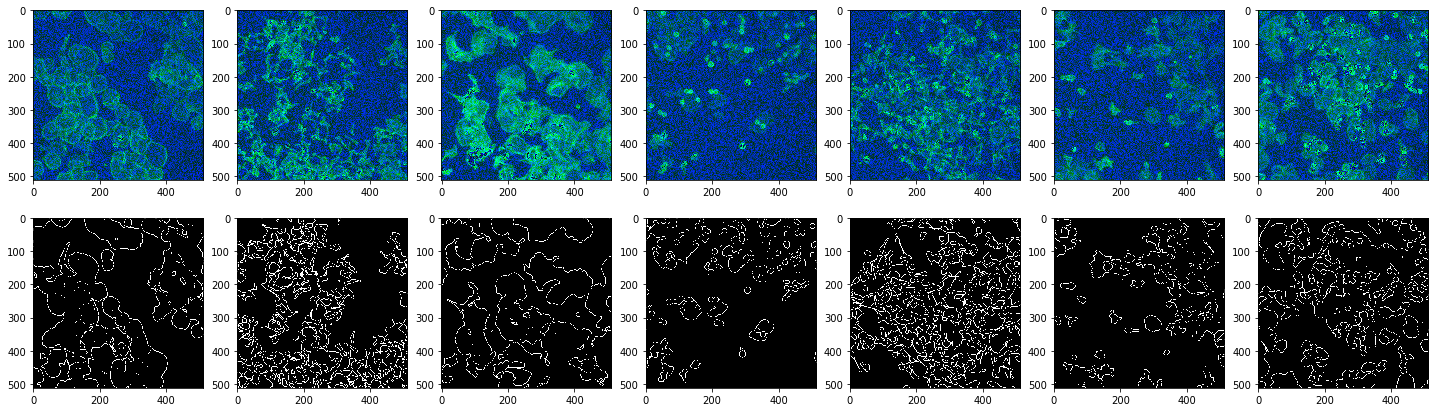

In [0]:
plt.figure(figsize=(25,7))
for i, img_path, gt in zip(range(mask_list.shape[0]), test_img_paths, mask_list):
    plt.subplot(2, len(mask_list), i+1)
    plt.imshow(sp.misc.imread(img_path))
    plt.subplot(2, len(mask_list), i+1 + mask_list.shape[0])
    plt.imshow(gt[0, 0, :, :], 'gray')

The result is not that good, butit is possible to see some contours.

Probably more data and more augmentation could improve the performance

In [0]:
# import glob

# train_img_paths = sorted(glob.glob('BBBC018_v1_images-fixed/train/*.bmp'))
# train_img_paths_ = []
# for path in train_img_paths: train_img_paths_.append(path)
# train_img_paths = train_img_paths_
# train_mask_paths = sorted(glob.glob('BBBC018_v1_outlines/train/*.png'))
# train_mask_paths_ = []
# for path in train_mask_paths: train_mask_paths_.append(path); train_mask_paths = train_mask_paths_

# val_img_paths = glob.glob('BBBC018_v1_images-fixed/val/*.bmp')
# val_img_paths_ = []; 
# for path in val_img_paths: val_img_paths_.append(path); val_img_paths = val_img_paths_
# val_mask_paths = glob.glob('BBBC018_v1_outlines/val/*.png')
# val_mask_paths_ = []; 
# for path in val_mask_paths: val_mask_paths_.append(path); val_mask_paths = val_mask_paths_

# print((train_img_paths))
# print((train_mask_paths))

# print(val_img_paths)
# print(val_mask_paths)
# # train_dataset = MyDataset(train_img_paths, train_mask_paths, transform_X=transform_X, transform_Y=transform_Y)
# # val_dataset = MyDataset(val_img_paths, val_mask_paths, transform_X=transform_test, transform_Y=None)

['BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/00736-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/03997-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/03998-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/03999-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/04000-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05621-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05622-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05623-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05897-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05898-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05900-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/07314-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/07315-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/07316-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/09338-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/09339-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/09340-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/10777-actin.DI